
# Nombre del Proyecto: Clasificador de Imágenes Piedra, Papel o Tijera con CNN

## Instalación del Dataset y Requerimientos

1. **Extnsiones en VS Code**: 
    -Descarga la extensión de Jupyter en VS code. 


2. **Requerimientos**:
    - Asegúrate de tener Python instalado (versión 3.11 o superior).
    - Instala las siguientes bibliotecas necesarias para el proyecto:
      ```bash
      pip install -r requirements.txt
      ```

3. **Ejecutar**:
    - Click en Run All

## Importación de dependencias

In [124]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.11.0
Tensorflow version: 2.19.0
Keras version: 3.9.2


## Cargando el dataset

Se va a descargar el dataset Rock-Paper-Scissors de la colección TensorFlow Datasets. Para eso se descargó el módulo tensorflow_datasets.

tensorflow_datasets define una colección de datasets listos para usar con TensorFlow.

Cada conjunto de datos se define como un tfds.core.DatasetBuilder, que encapsula la lógica para descargar el conjunto de datos y construir un pipeline de entrada, además de contener la documentación del conjunto de datos (versión, divisiones, número de ejemplos, etc.).

In [125]:
# Ver datsets disponibles

tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [82]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [83]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [84]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='tmp\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

In [85]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [86]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 6
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Se reduce el tamaño de las imágenes para acelerar el entrenamiento
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 50
Input image shape (reduced): (50, 50, 3)


Input image size: 50
Input image shape: (50, 50, 3)


In [87]:
# Función para convertir label ID a cadenas de etiquetas.
get_label_name = dataset_info.features['label'].int2str

In [88]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


## Explorando el dataset

In [89]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

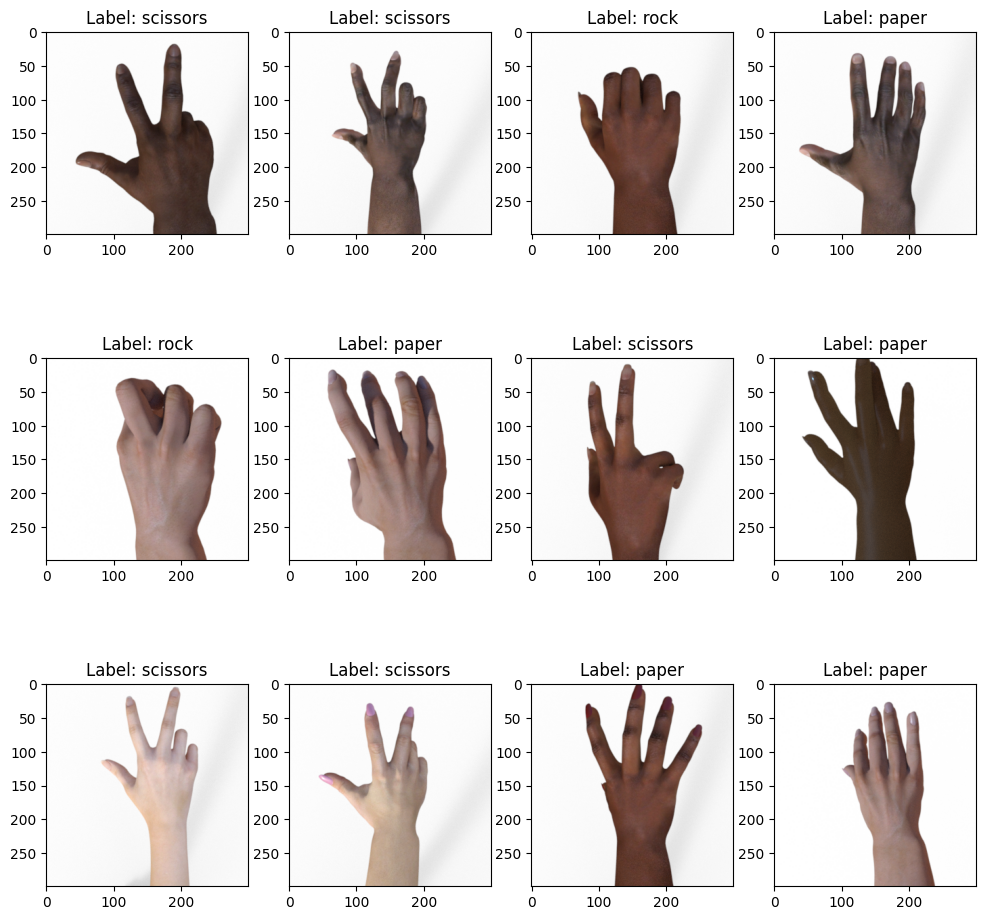

In [90]:
# Explorando las imagenes del dataset. 
preview_dataset(dataset_train_raw)

In [91]:
# Explorando que valores son usados para representar la imagen. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Preprocesando el dataset

In [92]:
def format_example(image, label):
    # Hacer que los colores de la imagen sean flotantes. 
    image = tf.cast(image, tf.float32)
    # Hacer que los valores de color de la imagen estén en el rango [0..1].
    image = image / 255
    
    #Convertir la imagen a escala de grises. 
    image = tf.image.rgb_to_grayscale(image)
    
    # Asegurarse de que la imagen tenga el tamaño correcto
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [136]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [94]:
# Explorando que valores son usados para representar la imagen.  
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (50, 50, 1) 

[[[0.9949986 ]
  [0.9949986 ]
  [0.99401826]
  ...
  [0.9842153 ]
  [0.98519564]
  [0.9812744 ]]

 [[0.99401826]
  [0.99401826]
  [0.99303794]
  ...
  [0.98519564]
  [0.9842153 ]
  [0.97931385]]

 [[0.99401826]
  [0.99303794]
  [0.9920577 ]
  ...
  [0.9842153 ]
  [0.983235  ]
  [0.9783336 ]]

 ...

 [[0.9861759 ]
  [0.9861759 ]
  [0.98715615]
  ...
  [0.9675503 ]
  [0.9695109 ]
  [0.9704912 ]]

 [[0.9881365 ]
  [0.98715615]
  [0.9881365 ]
  ...
  [0.9685306 ]
  [0.9675503 ]
  [0.9695109 ]]

 [[0.98715615]
  [0.9861759 ]
  [0.9842153 ]
  ...
  [0.9695109 ]
  [0.9714715 ]
  [0.9714715 ]]]


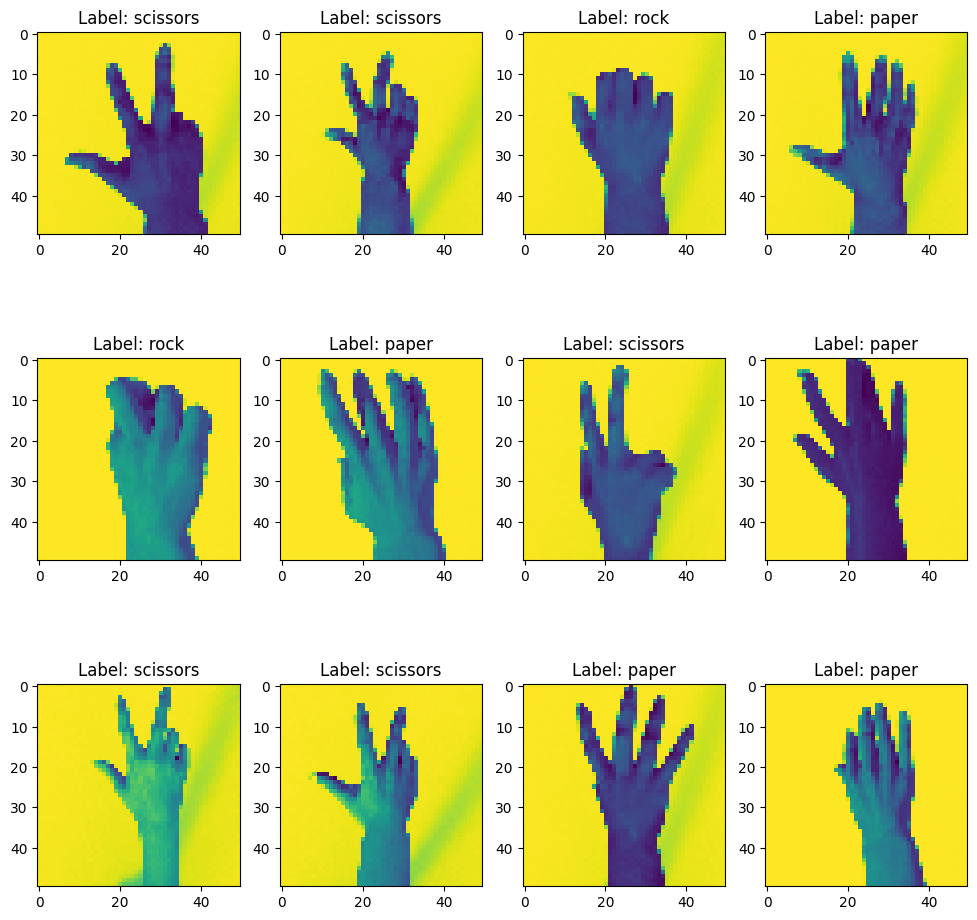

In [95]:
# Explorar las imagenes de entrenamiento del dataset. 
preview_dataset(dataset_train)

## Aumento de datos

Una de las maneras de combatir el sobreajuste del modelo y generalizarlo a un conjunto más amplio de ejemplos es aumentar los datos de entrenamiento.

Como se pudo ver en las imagenes anteriores, todos los ejemplos de entrenamiento tienen un fondo blanco y manos derechas posicionadas verticalmente. Pero, ¿qué pasaría si la imagen de la mano estuviera posicionada horizontalmente o si el fondo no fuera tan brillante? ¿Qué pasaría si en lugar de una mano derecha el modelo viera una mano izquierda? Para hacer que nuestro modelo sea un poco más universal, vamos a voltear y rotar las imágenes, y también a ajustar los colores de fondo.

In [96]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [97]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [98]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotar 0, 90, 180, 270 grados
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [99]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [100]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [101]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [102]:
dataset_train_augmented = dataset_train.map(augment_data)

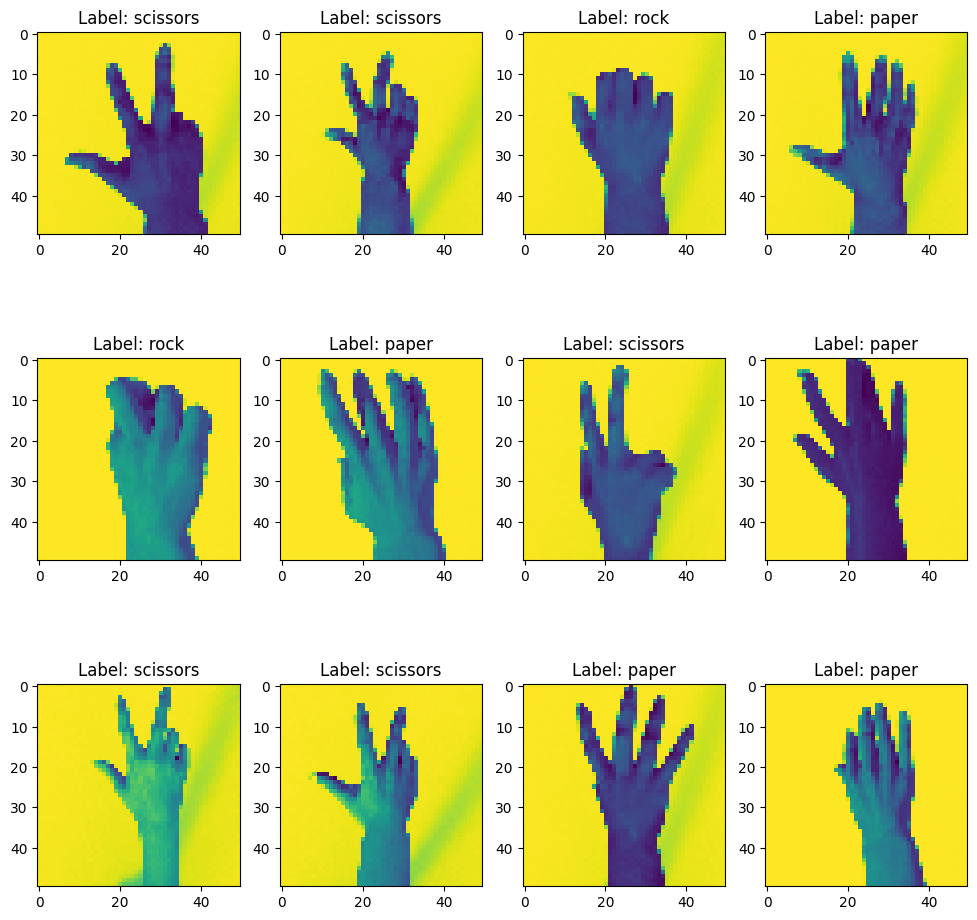

In [139]:
# Explorar el dataset de entrenamiento aumentado. 
preview_dataset(dataset_train)

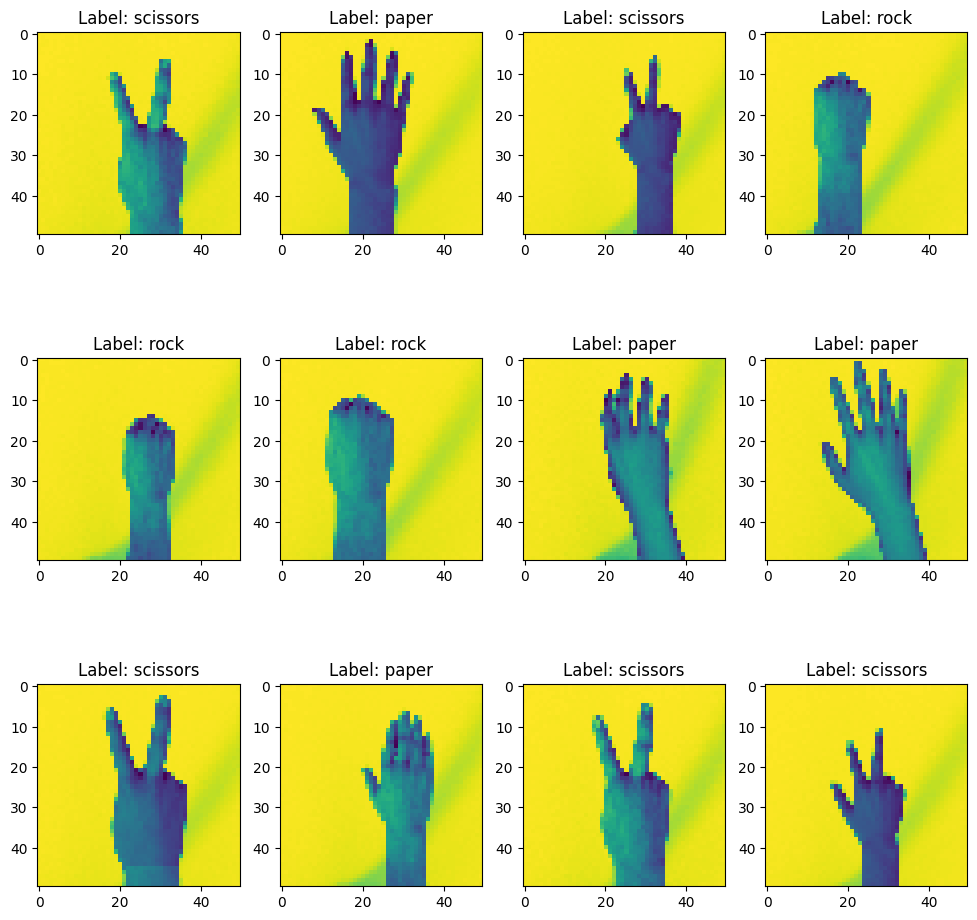

In [137]:
# Explora el dataset de prueba.
preview_dataset(dataset_test)

## Barajado de datos y procesamiento por lotes 

No se quiere que el modelo aprenda algo del orden o la agrupación de las imágenes en el conjunto de datos. Para evitarlo, se va a barajear los ejemplos de entrenamiento. También se va a dividr el conjunto de entrenamiento por lotes para hacer el proceso de entrenamiento más rápido y que consuma menos memoria. 

In [105]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train.batch(
    batch_size=BATCH_SIZE
)

# Prefetch permitirá que el pipeline de entrada obtenga lotes de forma asincrónica mientras su modelo está entrenando.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [106]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Label batch shape: (32,) 

Image batch shape: (32, 50, 50, 1) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.9949986 ]
  [0.9949986 ]
  [0.99401826]
  ...
  [0.9842153 ]
  [0.98519564]
  [0.9812744 ]]

 [[0.99401826]
  [0.99401826]
  [0.99303794]
  ...
  [0.98519564]
  [0.9842153 ]
  [0.97931385]]

 [[0.99401826]
  [0.99303794]
  [0.9920577 ]
  ...
  [0.9842153 ]
  [0.983235  ]
  [0.9783336 ]]

 ...

 [[0.9861759 ]
  [0.9861759 ]
  [0.98715615]
  ...
  [0.9675503 ]
  [0.9695109 ]
  [0.9704912 ]]

 [[0.9881365 ]
  [0.98715615]
  [0.9881365 ]
  ...
  [0.9685306 ]
  [0.9675503 ]
  [0.9695109 ]]

 [[0.98715615]
  [0.9861759 ]
  [0.9842153 ]
  ...
  [0.9695109 ]
  [0.9714715 ]
  [0.9714715 ]]] 



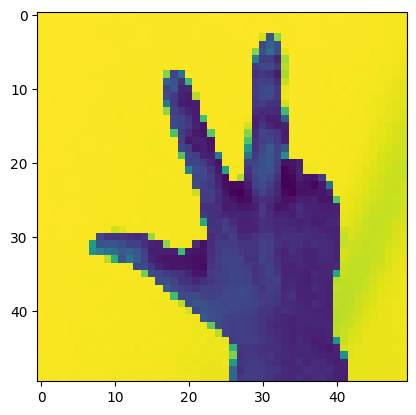

In [107]:
# Depuración de los lotes usando la conversión a matrices Numpy.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Parar para acortar la salida.
        break
    # Parar para acortar la salida.
    break

## Creando el modelo 

In [108]:
model = tf.keras.models.Sequential()

# Aplanar los resultados para alimentar las capas densas.
model.add(tf.keras.layers.Flatten(input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE, 1)))
model.add(tf.keras.layers.Dropout(0.5))

# Capa densa de 512 neuronas.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Capa de salida.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

c:\Users\karim\Desktop\proy1_ia_modelo\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,280,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,051 (4.89 MB)

 Trainable params: 1,282,051 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

## Compilando el modelo 

In [110]:
# Se usa el optimizador Adam para la optimización del modelo.
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [111]:
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [112]:
!rm -rf tmp/checkpoints
!rm -rf logs

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [113]:
# Preparando los callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [114]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3520 - loss: 7.1058 - val_accuracy: 0.3068 - val_loss: 1.0754
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4431 - loss: 1.1451 - val_accuracy: 0.4460 - val_loss: 1.2415
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5109 - loss: 1.0187 - val_accuracy: 0.5625 - val_loss: 1.1346
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5865 - loss: 0.9132 - val_accuracy: 0.4489 - val_loss: 1.1808
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6431 - loss: 0.8046 - val_accuracy: 0.5426 - val_loss: 1.1124
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6627 - loss: 0.7732 - val_accuracy: 0.4631 - val_loss: 1.0735
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7016 - loss: 0.7278 - val_accuracy: 0.5170 - val_loss: 0.8963
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7143 - loss: 0.6682 - val_accuracy: 0.4545 - val_loss

In [115]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

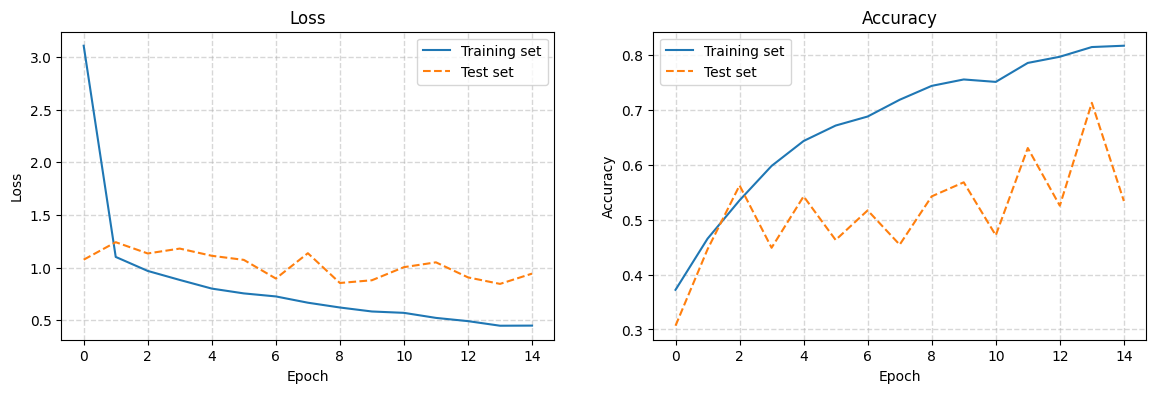

In [116]:
render_training_history(training_history)

## Evaluando la precisión del modelo 

In [117]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8883 - loss: 0.2599
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5474 - loss: 0.9042 


In [118]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.2601291239261627
Training accuracy:  0.8904761672019958


Test loss:  0.9471202492713928
Test accuracy:  0.5295698642730713


## Guardando el modelo 

In [119]:
model_name = 'rock_paper_scissors_mlp.h5'
model.save(model_name, save_format='h5')

## Probando el modelo con imagenes externas

In [120]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('rock_paper_scissors_mlp.h5')

In [121]:
import tensorflow as tf
import numpy as np
from PIL import Image

def preprocess_image(image_path, target_size):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño esperado
    img = img.resize(target_size)
    # Convertir la imagen a un array de NumPy
    img_array = np.array(img)
    
    #Convertir la imagen a un tensor de TensorFlow
    img_tensor = tf.convert_to_tensor(img_array,dtype=tf.float32)
    
    # Normalizar los valores de los píxeles al rango [0, 1]
    img_tensor = img_tensor / 255.0
    
    # Convertir la imagen a escalas grises
    img_tensor = tf.image.rgb_to_grayscale(img_tensor)
    # Expandir las dimensiones para que sea compatible con el modelo (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    return img_tensor

In [126]:
# Ruta de la imagen a probar
image_path = 'scissors.jpeg'

# Preprocesar la imagen
input_image = preprocess_image(image_path, target_size=(50, 50))  # Cambia (50, 50) si usaste otro tamaño

# Hacer la predicción
predictions = model.predict(input_image)

print('Predicciones:', predictions)


# Obtener la clase con mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)[0]

print(f'Predicción: Clase {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicciones: [[0.06308851 0.11746475 0.81944674]]
Predicción: Clase 2


In [123]:
# Convertir la clase predicha a su etiqueta
label_name = get_label_name(predicted_class)
print(f'La imagen pertenece a la clase: {label_name}')

La imagen pertenece a la clase: scissors
